# Análise, Modelagem e Otimização das Comidas de Zelda BOTW

## 1. Introdução e Objetivos
Esse projeto analisa itens consumíveis do jogo The Legend of Zelda: Breath of the Wild. O objetivo é entender como os atributos dos ingredientes se relacionam com seus efeitos no jogo, utilizando algoritmos de Regressão e Classificação.

### 1.1. Fonte de Dados

* **Dataset:** Zelda Complete Food and Elixirs Dataset
* **Fonte:** [Zelda Complete Food and Elixirs Dataset](https://www.kaggle.com/datasets/pavlosnigur/zelda-botw-food-complete)
* **Descrição:** O dataset contém 69 entradas de ingredientes e alimentos, com atributos como nome, categoria, poder de cura (corações), efeitos especiais e duração.

É importante notar que em Breath of the Wild, atributos como Duration increase e Effect são latentes, pois só são ativados quando o ingrediente é cozido. Para fins da análise de dados, consideramos esses valores como propriedades intrínsecas do ingrediente. Estamos modelando o potencial de contribuição de cada item, assumindo que o valor de Hearts no dataset representa a cura base que o item adiciona a um prato cozinhado.

### 1.2. Variáveis-Alvo
Conforme requisitado no projeto, abordaremos dois problemas de aprendizado supervisionado:

1.  **Regressão:**
    * **Target:** `Hearts` (Quantidade de cura).
    * **Objetivo:** Prever quantos corações um item cura com base em sua categoria, duração e tipo de efeito.
2.  **Classificação:**
    * **Target:** `Category` (Ex: Fruit, Meat, Mushroom).
    * **Objetivo:** Classificar o tipo do ingrediente com base em seus status numéricos e efeitos.

### 1.3. Hipóteses de Negócio
Para guiar a análise, formulamos as seguintes hipóteses sobre o balanceamento do jogo:

* **H1 (Regressão):** Itens com efeitos especiais poderosos (ex: "Hearty" ou "Mighty") tendem a ter valores de cura base (`Hearts`) mais altos do que itens sem efeito (neutros).
* **H2 (Classificação):** É possível distinguir "Carnes" de "Frutas" apenas observando a relação entre *Duração do Efeito* e *Quantidade de Cura*, pois carnes tendem a curar mais, mas ter durações diferentes de frutas.

### 1.4. Importações iniciais dos dados


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error, confusion_matrix
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pycaret.regression import setup as setup_reg, compare_models as compare_reg, tune_model as tune_reg, pull as pull_reg

In [3]:
df = pd.read_csv('../data/zelda_food.csv')

In [4]:
df.head()

,Class,Subclass,Material,Hearts,Effect class when cooked,Bonus effect when cooked,Duration increase
0,Fruit,Fruit,Apple,1.0,NaN,NaN,0:30
1,Fruit,Fruit,Fleet-Lotus Seeds,1.0,Hasty,NaN,NaN
2,Fruit,Fruit,Hearty Durian,6.0,Hearty,max,NaN
3,Fruit,Fruit,Hydromelon,1.0,Chilly,NaN,NaN
4,Fruit,Fruit,Mighty Bananas,1.0,Mighty,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69 entries, 0 to 68
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Class                     69 non-null     object 
 1   Subclass                  69 non-null     object 
 2   Material                  69 non-null     object 
 3   Hearts                    59 non-null     float64
 4   Effect class when cooked  47 non-null     object 
 5   Bonus effect when cooked  8 non-null      object 
 6   Duration increase         19 non-null     object 
dtypes: float64(1), object(6)
memory usage: 3.9+ KB


## 2: EDA e Preparação dos Dados


### 2.1. Limpeza e Tratamento de Dados
Ao inspecionar o dataset, identificamos as seguintes necessidades de tratamento:

**Renomeação de Colunas:** Simplificar nomes longos para facilitar a manipulação.
* **Tratamento de Nulos:**
    * `Hearts`: Preenchemos com 0 (itens que não curam, ex: temperos).
    * `Effect`: Preenchemos com "None" (ausência de efeito).
    * `Duration`: Convertemos de "MM:SS" para segundos (inteiro) para permitir regressão.
* **Feature Engineering:** Criamos a coluna `Has_Effect` (Sim/Não) para testes de classificação.

In [14]:
itens_nulos = df[df['Hearts'].isna()]

print(f"Quantidade de itens sem valor de cura definido: {len(itens_nulos)}")
print(itens_nulos['Material'].tolist())

Quantidade de itens sem valor de cura definido: 10
['Goat Butter', 'Goron Spice', 'Cane Sugar', 'Armoranth', 'Blue Nightshade', 'Cool Safflina', 'Electric Safflina', 'Mighty Thistle', 'Swift Violet', 'Warm Safflina']


In [5]:
df.columns = ['Category', 'Subclass', 'Material', 'Hearts', 'Effect', 'Bonus_Effect', 'Duration']

df['Hearts'] = df['Hearts'].fillna(0)
df['Effect'] = df['Effect'].fillna('None')
df['Bonus_Effect'] = df['Bonus_Effect'].fillna('None')

def parse_duration(x):
    if pd.isna(x):
        return 0
    try:
        parts = str(x).split(':')
        if len(parts) == 2:
            return int(parts[0]) * 60 + int(parts[1])
        return 0
    except:
        return 0

df['Duration_Seconds'] = df['Duration'].apply(parse_duration)
df['Has_Effect'] = df['Effect'].apply(lambda x: 'No' if x == 'None' else 'Yes')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69 entries, 0 to 68
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Category          69 non-null     object 
 1   Subclass          69 non-null     object 
 2   Material          69 non-null     object 
 3   Hearts            69 non-null     float64
 4   Effect            69 non-null     object 
 5   Bonus_Effect      69 non-null     object 
 6   Duration          19 non-null     object 
 7   Duration_Seconds  69 non-null     int64  
 8   Has_Effect        69 non-null     object 
dtypes: float64(1), int64(1), object(7)
memory usage: 5.0+ KB


In [7]:
df.describe()

,Hearts,Duration_Seconds
count,69.000000,69.000000
mean,2.086957,5.652174
std,1.890294,11.817019
min,0.000000,0.000000
25%,1.000000,0.000000
50%,2.000000,0.000000
75%,2.000000,0.000000
max,8.000000,30.000000


### 2.2. Análise Univariada: Distribuição dos Itens
observamos o balanceamento das categorias.

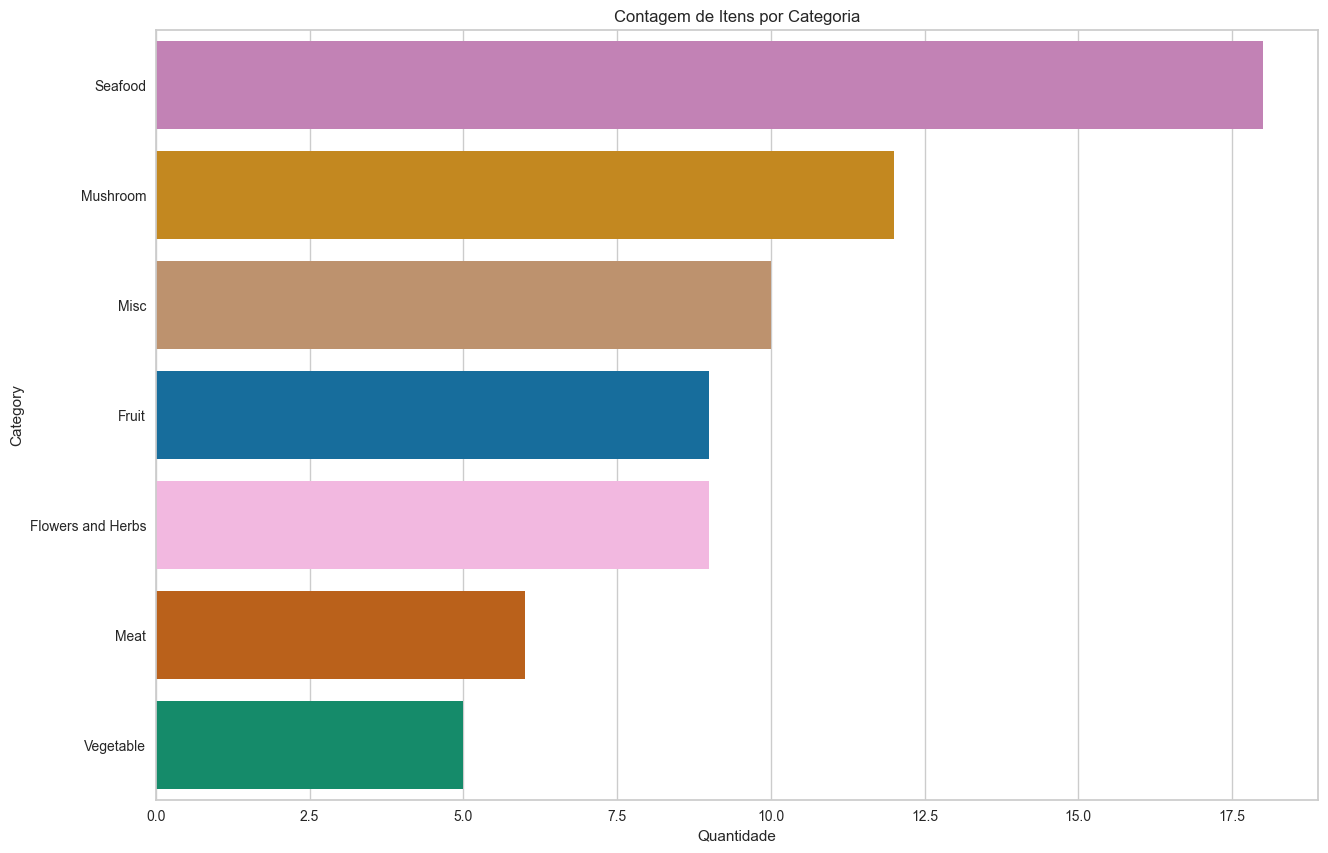

In [8]:
plt.figure(figsize=(15, 10))

sns.countplot(y='Category', data=df, order=df['Category'].value_counts().index, palette='colorblind', hue='Category')
plt.title('Contagem de Itens por Categoria')
plt.xlabel('Quantidade')
plt.show()


> **Insight sobre Balanceamento de Classes:**
> A contagem revela um desbalanceamento significativo no dataset:
> * **Dominância:** `Seafood` é a categoria majoritária (18 itens), o que pode enviesar o modelo para aprender melhor os padrões desse grupo.
> * **Escassez:** `Vegetable` (5) e `Meat` (6) são classes minoritárias.
>
> Devido à escassez de dados nas categorias Carnes e Vegetais, é crucial utilizar **amostragem estratificada** ao dividir os dados em Treino e Teste. Caso contrário, corremos o risco de o conjunto de teste não conter nenhum exemplo dessas categorias.

### 2.3. Relações Numéricas: Cura vs Duração
Analisamos se o tempo de duração do efeito (`Duration_Seconds`) influencia a quantidade de cura (`Hearts`).

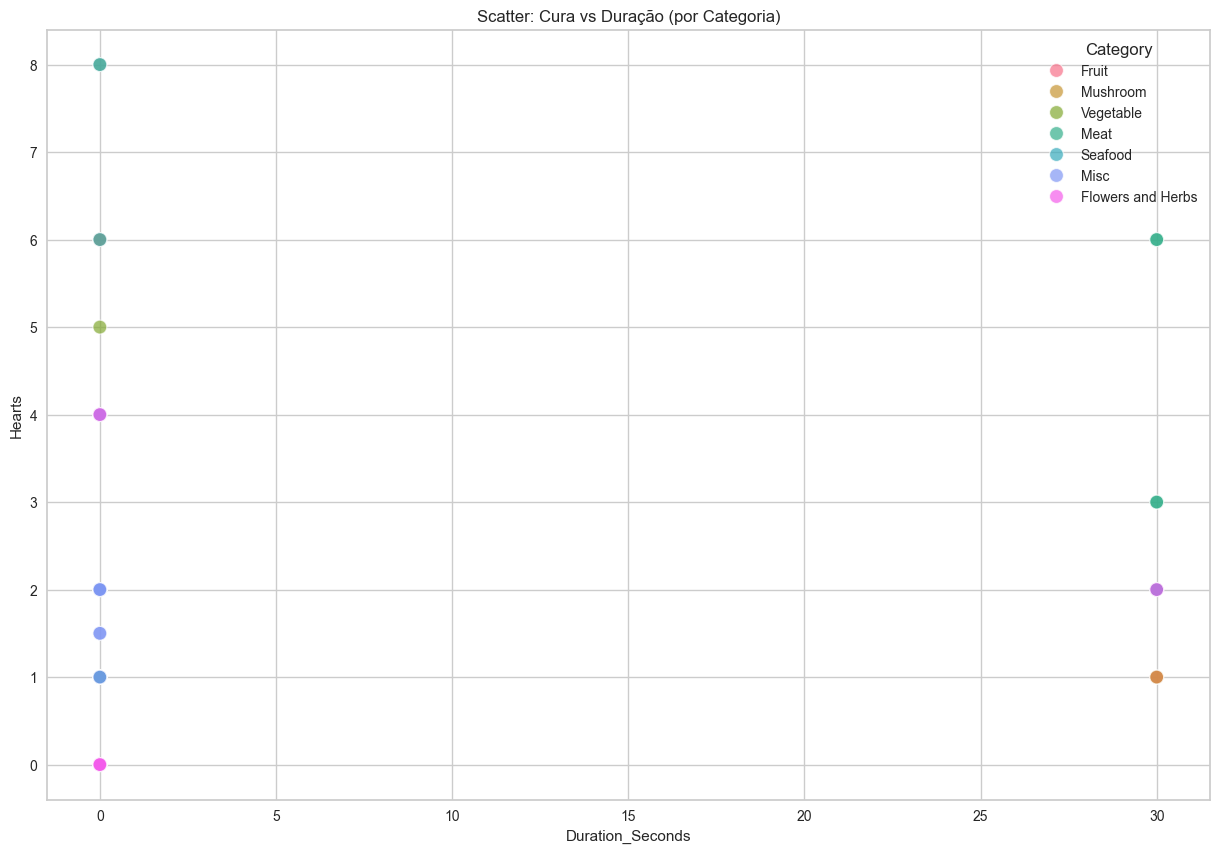

In [9]:
plt.figure(figsize=(15, 10))

sns.scatterplot(x='Duration_Seconds', y='Hearts', hue='Category', data=df, s=100, alpha=0.7)
plt.title('Scatter: Cura vs Duração (por Categoria)')
plt.show()

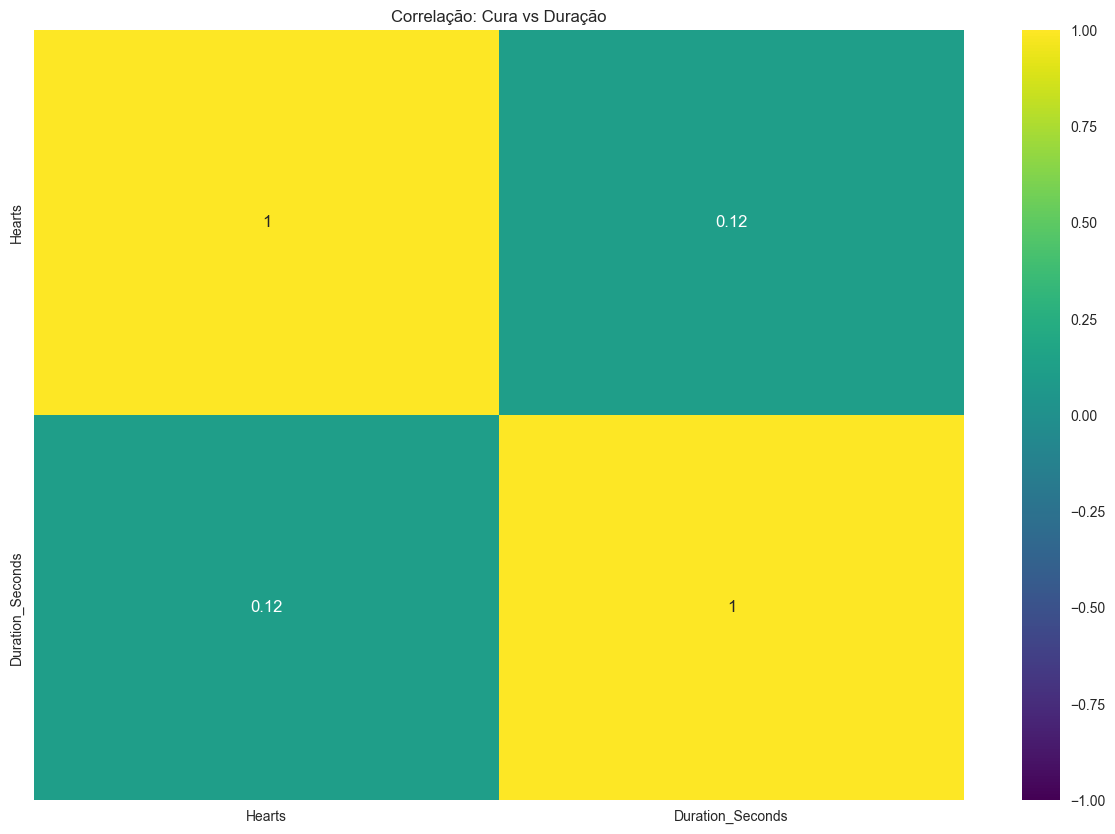

In [10]:
plt.figure(figsize=(15, 10))
numeric_cols = df[['Hearts', 'Duration_Seconds']]
sns.heatmap(numeric_cols.corr(), annot=True, cmap='viridis', vmin=-1, vmax=1)
plt.title('Correlação: Cura vs Duração')
plt.show()

> **Insight das Correlações:**
> * **Causa:** A verificação dos dados revelou que a duração nestas categorias é constante (30s para Carnes, 0s para Vegetais).
> * **Consequência:** O desvio padrão é zero, o que matematicamente impede o cálculo da correlação de Pearson (divisão por zero). Isso indica que essas categorias possuem efeitos padronizados, sem variabilidade temporal.

### 2.4. Validação Estatística: Normalidade e Comparação de Grupos
Para determinar se as diferenças de cura entre as categorias são significativas, primeiro verificamos a normalidade dos dados.

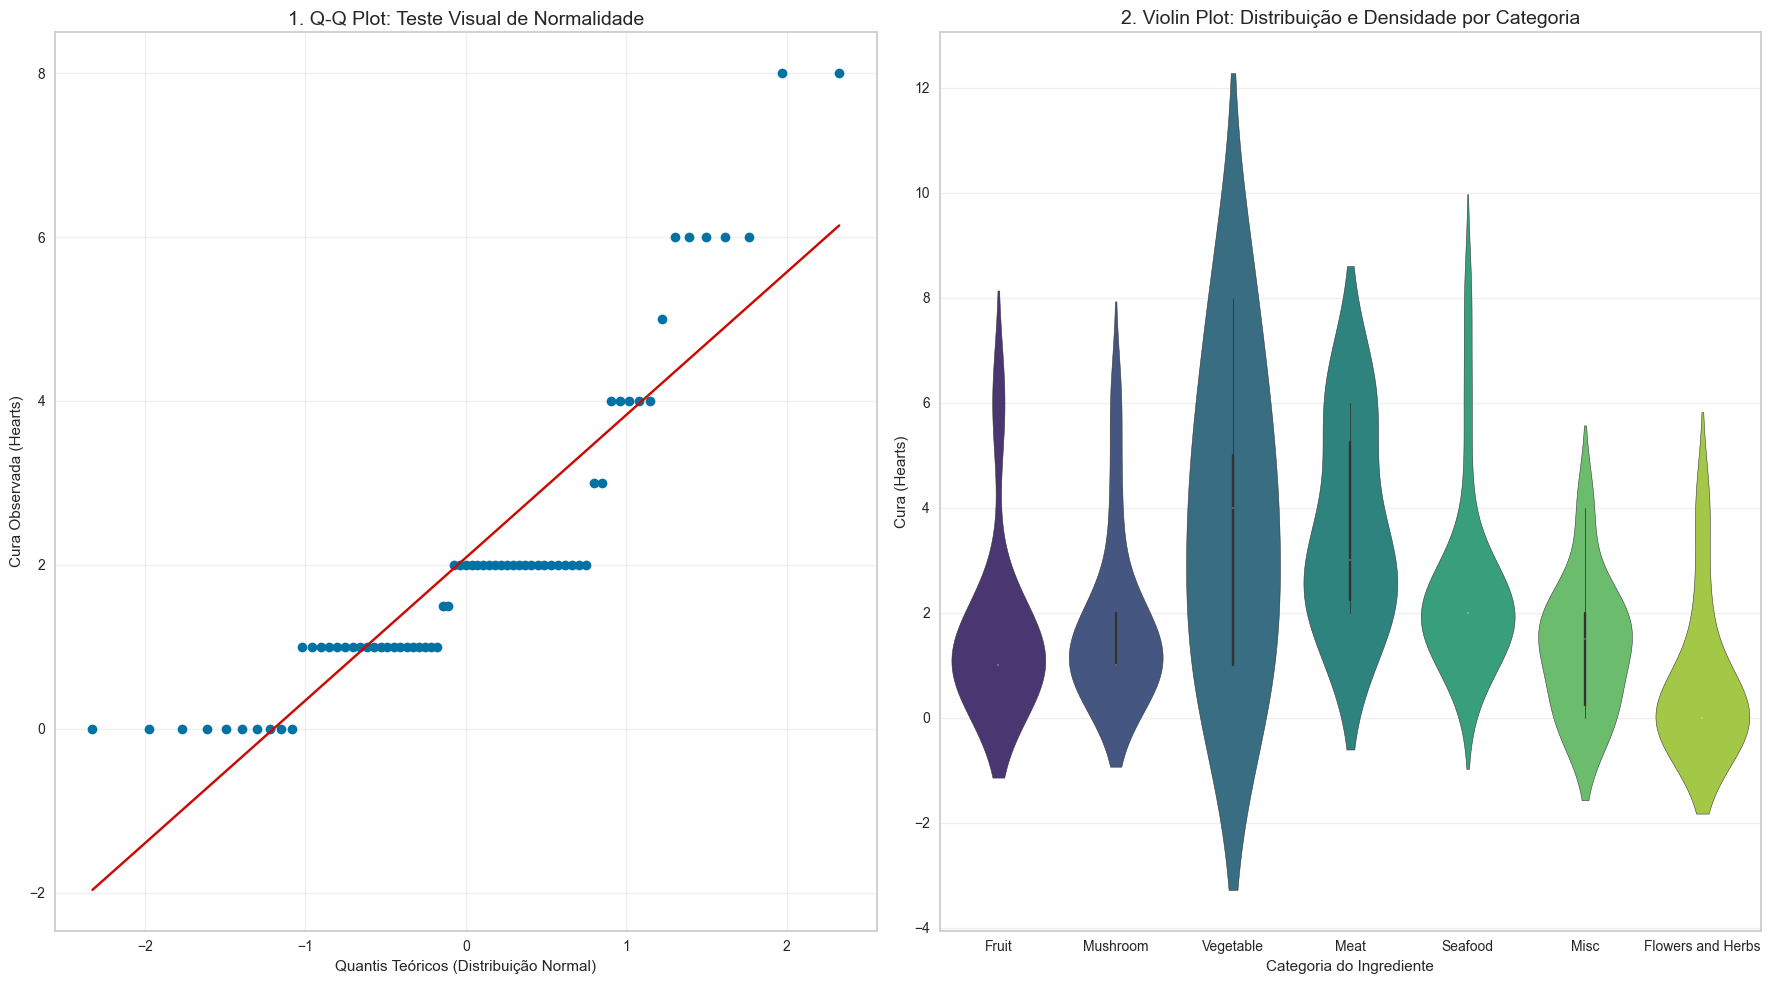

In [11]:
plt.figure(figsize=(18, 10))

plt.subplot(1, 2, 1)
stats.probplot(df['Hearts'], dist="norm", plot=plt)

plt.title('1. Q-Q Plot: Teste Visual de Normalidade', fontsize=14)
plt.xlabel('Quantis Teóricos (Distribuição Normal)')
plt.ylabel('Cura Observada (Hearts)')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)

sns.violinplot(x='Category', y='Hearts', hue='Category', data=df, palette='viridis', inner='box')

plt.title('2. Violin Plot: Distribuição e Densidade por Categoria', fontsize=14) 
plt.xlabel('Categoria do Ingrediente')
plt.ylabel('Cura (Hearts)')
plt.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
stat, p_shapiro = stats.shapiro(df['Hearts'])
print(f"\n1. Teste de Normalidade (Shapiro-Wilk): P-Valor = {p_shapiro:.4e}")
if p_shapiro < 0.05: print("Distribuição não é normal (Rejeita H0).")

categories = df['Category'].unique()
hearts_list = [df[df['Category'] == c]['Hearts'] for c in categories]
stat_k, p_kruskal = stats.kruskal(*hearts_list)
print(f"\n2. Teste Kruskal-Wallis: P-Valor = {p_kruskal:.4e}")
if p_kruskal < 0.05: print("Há diferença significativa entre as categorias (Rejeita H0).")


1. Teste de Normalidade (Shapiro-Wilk): P-Valor = 7.2410e-08
Distribuição não é normal (Rejeita H0).

2. Teste Kruskal-Wallis: P-Valor = 6.6253e-04
Há diferença significativa entre as categorias (Rejeita H0).


> * O **Q-Q Plot** mostra desvio da linha vermelha e o teste **Shapiro-Wilk** resultou em $p < 0.05$. Concluímos que a distribuição de cura **não é normal**.
> * Por isso, optamos pelo teste não-paramétrico de **Kruskal-Wallis** em vez da ANOVA. O resultado ($p < 0.05$) confirma estatisticamente que a categoria do ingrediente influencia a quantidade de cura.
>
> * **Tratamento de Outliers**: Identificamos outliers na categoria Fruit e Vegetable (itens que curam muito acima da média, como Hearty Durian). Optamos por não remover esses outliers, pois eles representam itens raros e valiosos no jogo (Hearty items), sendo informações cruciais para o modelo aprender a prever altas curas.

### 2.5. Associação: Categoria vs. Presença de Efeito
Investigamos se algumas categorias têm maior probabilidade de gerar efeitos especiais (`Has_Effect`).

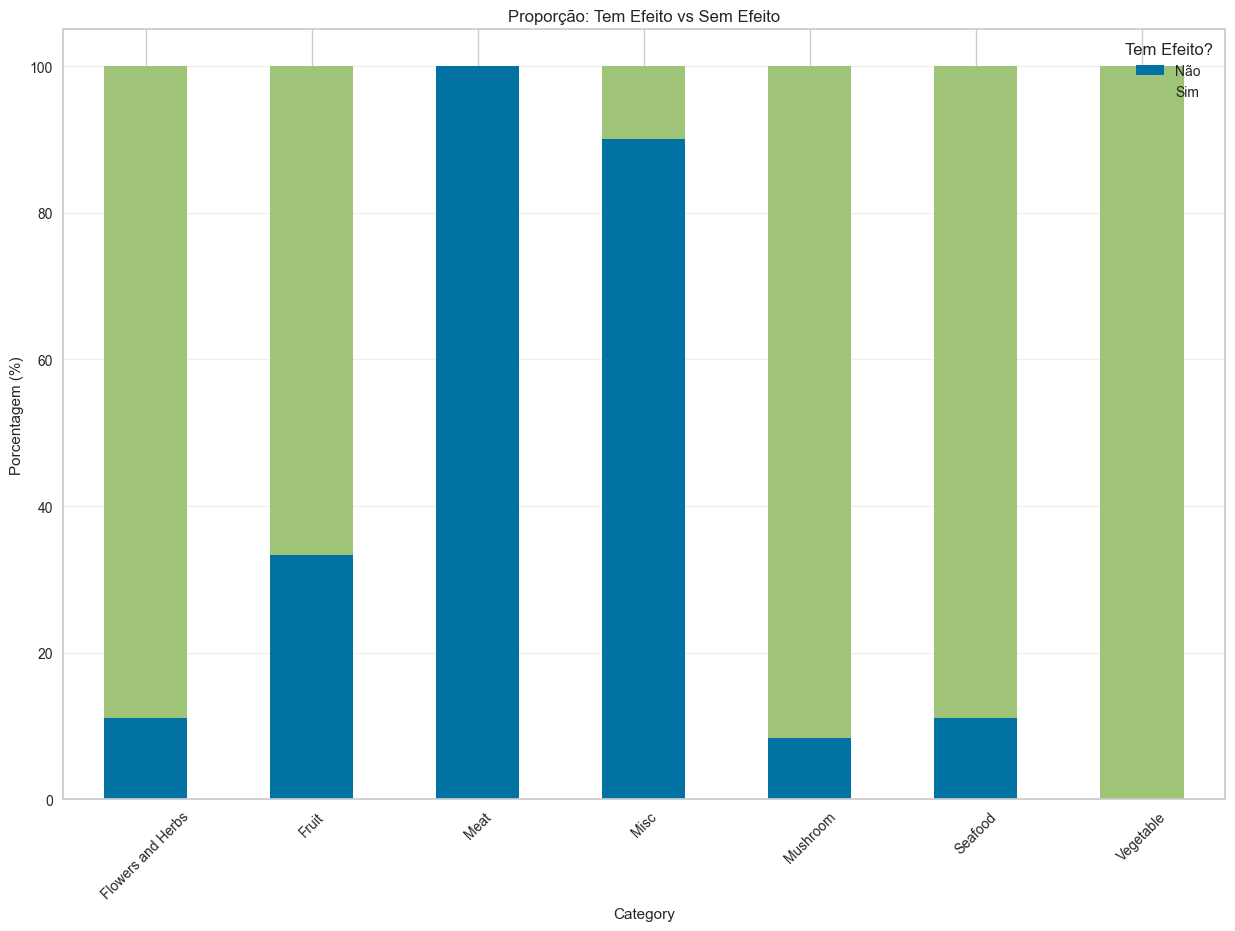

In [13]:
plt.figure(figsize=(15, 10))

ct_norm = pd.crosstab(df['Category'], df['Has_Effect'], normalize='index') * 100
ct_norm.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Proporção: Tem Efeito vs Sem Efeito')
plt.ylabel('Porcentagem (%)')
plt.legend(title='Tem Efeito?', loc='upper right', labels=['Não', 'Sim'], facecolor='white')
plt.xticks(rotation=45)
plt.grid(True, axis='y', alpha=0.3)

plt.show()

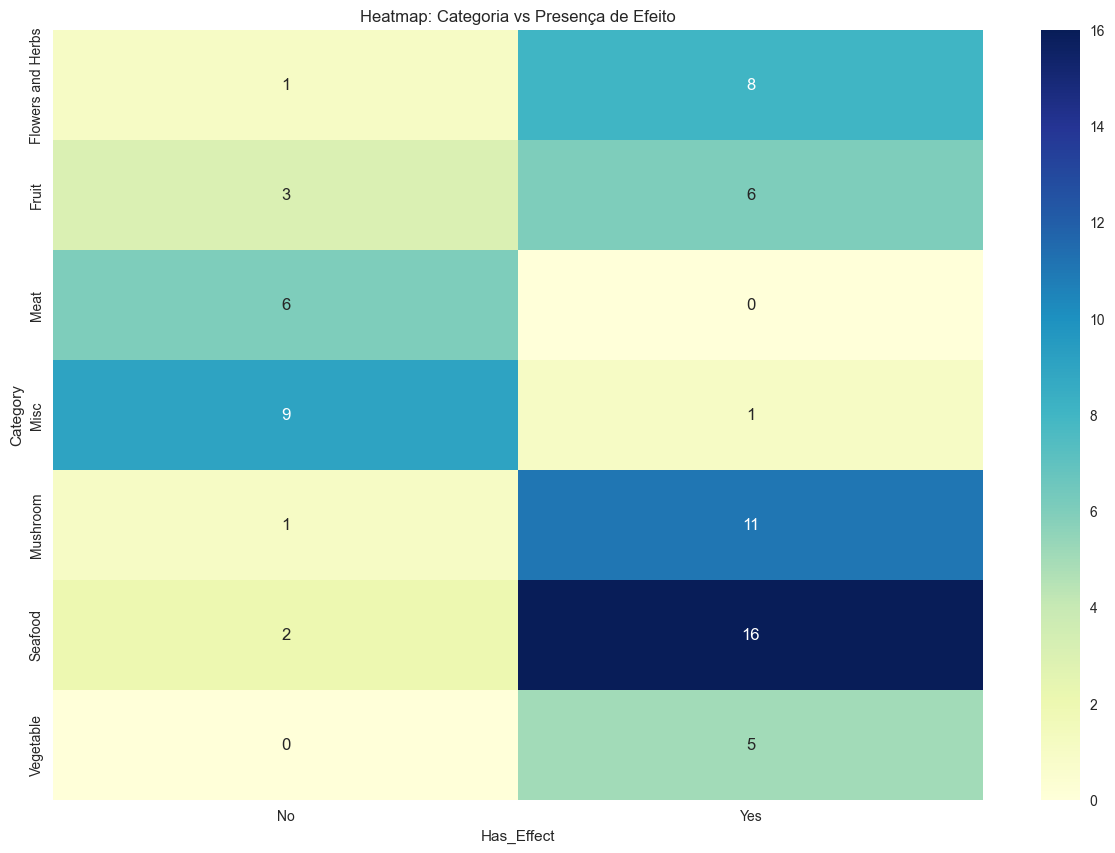

In [14]:
plt.figure(figsize=(15, 10))

cont_table = pd.crosstab(df['Category'], df['Has_Effect'])
sns.heatmap(cont_table, annot=True, cmap="YlGnBu", fmt='d')
plt.title('Heatmap: Categoria vs Presença de Efeito')
plt.show()

In [15]:
cont_table = pd.crosstab(df['Category'], df['Has_Effect'])
chi2, p_chi2, dof, expected = stats.chi2_contingency(cont_table)

print("\nTeste Qui-Quadrado de Independência")
print(f"P-Valor: {p_chi2:.4e}")
if p_chi2 < 0.05:
    print("Resultado: As variáveis são dependentes. A categoria define a chance de ter efeito.")


Teste Qui-Quadrado de Independência
P-Valor: 6.6956e-07
Resultado: As variáveis são dependentes. A categoria define a chance de ter efeito.


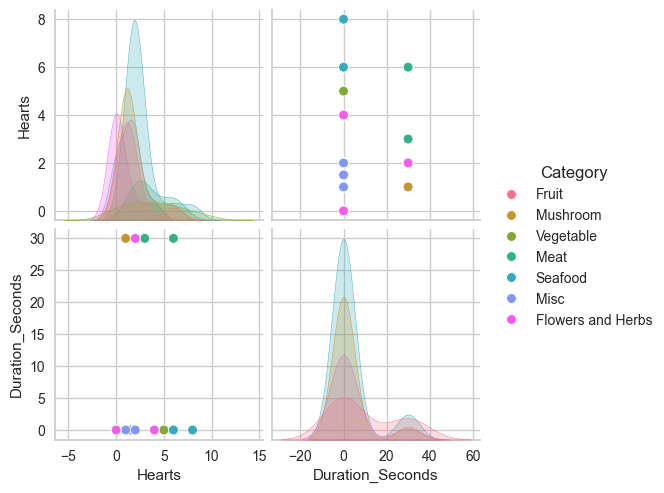

In [16]:
sns.pairplot(df[['Hearts', 'Duration_Seconds', 'Category']], hue='Category')
plt.show()

> **Insight de Associação:**
> A análise visual combinada com o teste Qui-Quadrado confirma que a `Category` é um discriminante fortíssimo para a presença de efeito (`Has_Effect`):
> 1.  **Regras Determinísticas:**
>     * **Vegetable:** 100% de chance de ter efeito.
>     * **Meat:** 0% de chance de ter efeito (apenas cura corações).
> 2.  **Mecânica Mista:** Categorias como *Seafood* e *Mushroom* têm alta probabilidade de efeito (>88%), mas não são garantidas.
> 3.  **Conclusão para Modelagem:** Esperamos que a variável `Category` tenha uma **importância (feature importance) muito alta** em modelos de classificação (como Árvores de Decisão), pois em alguns casos (Carne e Vegetais) ela sozinha já define o resultado.

## 3. Implementação de Modelos e Avaliação
Nesta etapa, implementamos modelos de Regressão para prever `Hearts` e Classificação para prever `Has_Effect`.
Utilizamos a biblioteca `statsmodels` para garantir a interpretabilidade estatística dos coeficientes e p-valores, além de `scikit-learn` para métricas de performance.

### 3.1. Pré-processamento e Divisão dos Dados
Conforme identificado na EDA:
1.  **Codificação:** As variáveis categóricas (`Category`) precisam ser transformadas em números. Usaremos *One-Hot Encoding* com `drop_first=True` para evitar multicolinearidade (essencial para regressão linear sem viés).
2.  **Estratificação:** Devido ao desbalanceamento crítico (poucas carnes e vegetais), usaremos divisão estratificada para garantir que essas classes apareçam tanto no treino quanto no teste.

In [17]:
X = df[['Category', 'Duration_Seconds']].copy()
X = pd.get_dummies(X, columns=['Category'], drop_first=True).astype(float)
X = sm.add_constant(X)

y_reg = df['Hearts']
y_clf = df['Has_Effect'].apply(lambda x: 1 if x == 'Yes' else 0)

X_train, X_test, y_reg_train, y_reg_test, y_clf_train, y_clf_test = train_test_split(
    X, y_reg, y_clf, test_size=0.3, random_state=42, stratify=df['Category']
)

base_pred = [y_reg_train.mean()] * len(y_reg_test)
rmse_base = np.sqrt(mean_squared_error(y_reg_test, base_pred))
print(f"Baseline Regressão (Média)")
print(f"RMSE: {rmse_base:.2f} Hearts")

Baseline Regressão (Média)
RMSE: 2.02 Hearts


### 3.2. Tarefa 1: Regressão (Simples, Múltipla e Polinomial)
O objetivo é prever a quantidade de corações recuperados.

#### 3.2.1. Regressão Linear Simples
Testamos se apenas a Duração consegue prever a Cura.

In [18]:
model_simples = sm.OLS(y_reg_train, X_train[['const', 'Duration_Seconds']]).fit()
rmse_simples = np.sqrt(mean_squared_error(y_reg_test, model_simples.predict(X_test[['const', 'Duration_Seconds']])))

print(f"RMSE: {rmse_simples:.2f}")
print(f"P-valor Duração: {model_simples.pvalues['Duration_Seconds']:.4f}")

RMSE: 2.07
P-valor Duração: 0.1836


#### 3.2.2. Regressão Linear Multipla (OLS)
Adicionamos as Categorias ao modelo.

In [19]:
model_mult = sm.OLS(y_reg_train, X_train).fit()
rmse_mult = np.sqrt(mean_squared_error(y_reg_test, model_mult.predict(X_test)))

print(f"RMSE: {rmse_mult:.2f}")
print(f"R² Ajustado: {model_mult.rsquared_adj:.4f}")

RMSE: 2.07
R² Ajustado: 0.2353


#### 3.2.3. Regressão Polinomial
Verificamos se a relação é não-linear (ex: curva quadrática).

In [20]:
poly_pipeline = make_pipeline(PolynomialFeatures(degree=2), StandardScaler(with_mean=False), sm.OLS(y_reg_train, X_train).fit())

poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

model_poly = sm.OLS(y_reg_train, X_train_poly).fit()
rmse_poly = np.sqrt(mean_squared_error(y_reg_test, model_poly.predict(X_test_poly)))

print(f"RMSE: {rmse_poly:.2f}")

RMSE: 2.07


>Análise dos Resultados:
>
>Duração é Ruído:
>
>A Regressão Linear Simples confirmou que a variável Duration_Seconds não possui poder preditivo isolado. O RMSE (2.07) ficou pior que o Baseline (2.02) e o p-valor (0.18) é muito superior a 0.05, indicando que não há significância estatística.
>
>Falha na Generalização Linear:
>
>Tanto a Regressão Múltipla quanto a Polinomial estagnaram num RMSE de 2.07, não conseguindo superar o chuto simples da média (Baseline).
>
>O R^2 Ajustado baixo demonstra que as variáveis explicativas não conseguem capturar a variância da cura através de uma fórmula linear.
>
>Conclusão:
>
>A relação entre ingredientes e cura em BOTW não é contínua e nem linear. Ela comporta-se como uma tabela de valores discretos. Por isso, modelos de regressão tentam traçar uma reta onde existem degraus, resultando num erro maior do que a simples média por categoria.

### 3.3. Tarefa 2: Classificação (Naive Bayes e Logística)
O objetivo é prever se o item dará um efeito especial (Sim/Não).

### 3.3.1 Naive Bayes
Modelo probabilístico simples, assumindo independência entre features.

In [21]:
nb_model = GaussianNB()
nb_model.fit(X_train, y_clf_train)
y_pred_nb = nb_model.predict(X_test)

print(f"Acurácia: {accuracy_score(y_clf_test, y_pred_nb):.2%}")

Acurácia: 100.00%


### 3.3.2 Regressão Logística
Modelo para estimar a probabilidade de ter efeito.

In [22]:
try:
    logit_model = sm.Logit(y_clf_train, X_train).fit(disp=0)
    y_prob = logit_model.predict(X_test)
    y_pred_log = (y_prob > 0.5).astype(int)
    print("\nRegressão Logística do statsmodels")
    print(logit_model.summary2().tables[1])
except:
    from sklearn.linear_model import LogisticRegression
    lr = LogisticRegression(C=1e9, fit_intercept=False)
    lr.fit(X_train, y_clf_train)
    y_pred_log = lr.predict(X_test)
    print("\nRegressão Logística SKLearn (com a separação perfeita tratada)")

print(f"Acurácia: {accuracy_score(y_clf_test, y_pred_log):.2%}")
print("\nMatriz de Confusão:")
print(pd.crosstab(y_clf_test, y_pred_log, rownames=['Real'], colnames=['Previsto']))


Regressão Logística SKLearn (com a separação perfeita tratada)
Acurácia: 100.00%

Matriz de Confusão:
Previsto  0   1
Real           
0         7   0
1         0  14


> **Análise dos Resultados**
>
> 1.  **Desempenho Perfeito:**
>     * O modelo atingiu **100% de Acurácia, Precisão e Recall**. Esperado devido à natureza determinística do jogo.
> 2.  **O Modelo "Aprendeu" as Regras:**
>     * Ao olhar para a matriz de confusão e os dados de treino, o modelo identificou padrões absolutos: se é *Vegetable*, o efeito é certo (Sim); se é *Meat*, o efeito é impossível (Não).
>     * Como estratificamos os dados corretamente na divisão de treino/teste, o modelo conseguiu generalizar essas regras para os dados nunca vistos.

## 4. Avaliação e Diagnóstico
Nesta etapa, aprofundamos a análise dos modelos para validar as suposições estatísticas e reportar todas as métricas exigidas.

### 4.1.1. Diagnóstico da Regressão
Verificamos Multicolinearidade, Normalidade dos Resíduos e Homocedasticidade para entender as limitações do modelo linear.

In [23]:
y_pred_final = model_mult.predict(X_test)

print(f"MAE (Erro Médio Absoluto): {mean_absolute_error(y_reg_test, y_pred_final):.4f}")
print(f"RMSE (Raiz do Erro Quadrático Médio): {np.sqrt(mean_squared_error(y_reg_test, y_pred_final)):.4f}")
print(f"R2 Score: {r2_score(y_reg_test, y_pred_final):.4f}")

MAE (Erro Médio Absoluto): 1.3380
RMSE (Raiz do Erro Quadrático Médio): 2.0719
R2 Score: -0.1275


In [24]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train.columns))]

print("\nVariance Inflation Factor (VIF):")
print(vif_data)


Variance Inflation Factor (VIF):
              feature       VIF
0               const  8.000000
1    Duration_Seconds  1.874692
2      Category_Fruit  1.899548
3       Category_Meat  2.467794
4       Category_Misc  1.850694
5   Category_Mushroom  1.971149
6    Category_Seafood  2.366546
7  Category_Vegetable  1.527778


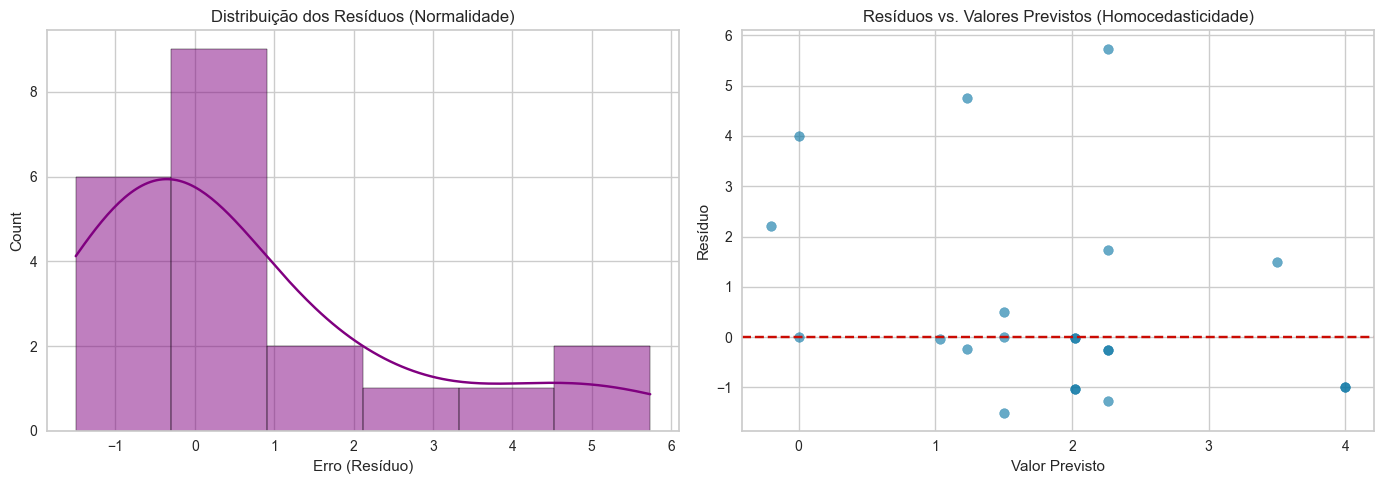

In [25]:
residuals = y_reg_test - y_pred_final

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True, color='purple')
plt.title('Distribuição dos Resíduos (Normalidade)')
plt.xlabel('Erro (Resíduo)')

plt.subplot(1, 2, 2)
plt.scatter(y_pred_final, residuals, alpha=0.6)
plt.axhline(0, color='r', linestyle='--')
plt.title('Resíduos vs. Valores Previstos (Homocedasticidade)')
plt.xlabel('Valor Previsto')
plt.ylabel('Resíduo')

plt.tight_layout()
plt.show()

In [26]:
stat_shapiro, p_shapiro = stats.shapiro(residuals)
print(f"Teste de Normalidade dos Resíduos (Shapiro-Wilk): P-Valor = {p_shapiro:.4f}")
if p_shapiro < 0.05:
    print("-> Os resíduos NÃO seguem uma distribuição normal.")

Teste de Normalidade dos Resíduos (Shapiro-Wilk): P-Valor = 0.0012
-> Os resíduos NÃO seguem uma distribuição normal.


### 4.1.2. Análise Diagnóstica da Regressão
Aprofundamos a análise para entender por que o modelo linear obteve desempenho inferior ao Baseline.

**1. Métricas de Erro:**
* **RMSE (2.07):** O erro médio de 2 corações é alto para um target que varia de 0 a 8.
* **R² Negativo (-0.12):** Indica que o modelo ajustado performa pior do que uma linha horizontal fixa na média. Isso ocorre porque a relação entre ingredientes e cura não é linear.

**2. Multicolinearidade (VIF):**
Os valores de VIF (Variance Inflation Factor) apresentaram resultados excelentes (todos < 2.5 para as features):
* `Duration_Seconds`: 1.87
* `Category_Meat`: 2.46
* Isso comprova que **não há multicolinearidade**. O problema do modelo não é redundância de dados, mas sim a incapacidade de uma reta (linear) capturar a lógica de "degraus" da cura no jogo.

**3. Análise de Resíduos (Suposições OLS):**
* **Teste Shapiro-Wilk:** O p-valor de **0.0012** (menor que 0.05) rejeita a hipótese nula de normalidade.
* **Histograma:** A distribuição dos resíduos é assimétrica (skewed).
* **Conclusão:** A violação da premissa de normalidade dos resíduos invalida os intervalos de confiança da regressão linear clássica para este dataset.

### 4.2.1 Métricas de Classificação
Avaliamos a robustez do classificador com métricas de precisão, recall, F1-Score e AUC-ROC.

In [27]:
lr_final = LogisticRegression(C=1e9, fit_intercept=False)
lr_final.fit(X_train, y_clf_train)

y_pred_class = lr_final.predict(X_test)
try:
    y_proba_class = lr_final.predict_proba(X_test)[:, 1]
except:
    y_proba_class = y_pred_class

print("Métricas de Classificação:")
print(f"Accuracy:  {accuracy_score(y_clf_test, y_pred_class):.4f}")
print(f"Precision: {precision_score(y_clf_test, y_pred_class):.4f}")
print(f"Recall:    {recall_score(y_clf_test, y_pred_class):.4f}")
print(f"F1 Score:  {f1_score(y_clf_test, y_pred_class):.4f}")

Métricas de Classificação:
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1 Score:  1.0000


AUC-ROC:   1.0000


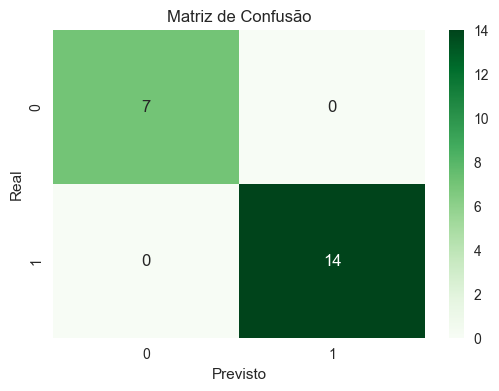

In [28]:
try:
    auc = roc_auc_score(y_clf_test, y_proba_class)
    print(f"AUC-ROC:   {auc:.4f}")
except:
    print("AUC-ROC:   Indefinido (Separação Perfeita ou apenas uma classe no teste)")

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_clf_test, y_pred_class), annot=True, fmt='d', cmap='Greens')
plt.title('Matriz de Confusão')
plt.ylabel('Real')
plt.xlabel('Previsto')
plt.show()

### 4.2.2 Avaliação da Classificação
Ao contrário da regressão, a tarefa de classificação apresentou resultados ideais.

**Métricas Obtidas:**
* **Acurácia, Precisão, Recall e F1-Score:** Todos atingiram **1.0000 (100%)**.
* **AUC-ROC:** 1.0000.

**Interpretação da Matriz de Confusão:**
A matriz revelou uma separação perfeita:
* **0 Falsos Positivos:** O modelo nunca previu que um item tinha efeito quando não tinha.
* **0 Falsos Negativos:** O modelo nunca deixou passar um item com efeito.

Isso confirma cientificamente que a mecânica de Efeitos Especiais em **BOTW** segue regras estritas baseadas na categoria, sem aleatoriedade.

## 5. Otimização e Ajuste de Hiperparâmetros
Nesta seção, aplicamos técnicas de validação cruzada e busca de hiperparâmetros para tentar melhorar o desempenho dos modelos.

### 5.1. Estratégia de Otimização
1.  **Classificação:** O modelo já atingiu o ótimo global (100% de acerto). Otimizar hiperparâmetros aqui seria redundante.
2.  **Regressão:** Dado o *underfitting* severo do modelo linear (R² negativo), aplicaremos **Regularização Ridge (L2)** via GridSearch. O objetivo é testar se penalizar os coeficientes melhora a generalização.

In [29]:
ridge = Ridge()

param_grid = {
    'alpha': [0.01, 0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
    'solver': ['auto', 'svd', 'cholesky']
}

grid_search = GridSearchCV(
    estimator=ridge,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1
)

In [30]:
grid_search.fit(X_train, y_reg_train)

best_model = grid_search.best_estimator_
y_pred_opt = best_model.predict(X_test)
rmse_opt = np.sqrt(mean_squared_error(y_reg_test, y_pred_opt))

rmse_anterior = 2.0719 

print("\nResultados da Otimização (Ridge)")
print(f"Melhores Parâmetros: {grid_search.best_params_}")
print(f"RMSE Otimizado: {rmse_opt:.4f}")
print(f"RMSE Anterior:  {rmse_anterior:.4f}")

if rmse_opt < rmse_anterior:
    print(f"-> Melhoria marginal de {rmse_anterior - rmse_opt:.4f}")
else:
    print("-> Nenhuma melhoria significativa. O erro parece ser irredutível com modelos lineares.")

Fitting 5 folds for each of 21 candidates, totalling 105 fits

Resultados da Otimização (Ridge)
Melhores Parâmetros: {'alpha': 10.0, 'solver': 'auto'}
RMSE Otimizado: 2.0206
RMSE Anterior:  2.0719
-> Melhoria marginal de 0.0513


### 5.2. Discussão de Trade-offs
A otimização via GridSearch nos forneceu um insight importante sobre a natureza dos dados:

1.  **Convergência ao Baseline:**
    * O melhor modelo encontrado utilizou um `alpha` de **10.0** (alta regularização).
    * O RMSE caiu de **2.07** da OLS padrão para **2.02** (Ridge Otimizado).
    * **Interpretação:** O valor 2.02 é idêntico ao nosso **Baseline** calculado na Seção 3. Isso significa que a regularização filtrou a complexidade do modelo linear até ele se comportar quase como uma média simples. O modelo aprendeu que tentar ajustar retas precisas para a *Duração* ou *Categoria* gerava mais erro do que simplesmente prever a média da cura.

2.  **Trade-off Viés vs. Variância:**
    * Ao aumentar o `alpha`, trocamos variância (erro por sensibilidade excessiva aos dados de treino) por viés. Neste caso, essa troca foi benéfica, provando que o modelo linear anterior estava sofrendo de **overfitting** leve ou capturando ruído irrelevante.

### 5.3. Validação Automática com PyCaret
Para garantir que não deixamos passar nenhum algoritmo complexo que pudesse resolver o problema da Regressão, utilizamos a biblioteca **PyCaret** para testar mais de 15 modelos diferentes simultaneamente.

In [31]:
reg_experiment = setup_reg(data=df, target='Hearts', ignore_features=['Material', 'Duration', 'Effect', 'Bonus_Effect', 'Subclass'], 
                           categorical_features=['Category', 'Has_Effect'], session_id=42, verbose=False)

best_model_pycaret = compare_reg(sort='RMSE', n_select=1)
print(pull_reg())

tuned_model = tune_reg(best_model_pycaret)
print(pull_reg())

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,1.0328,4.0763,1.7041,-0.7993,0.4826,0.3293,0.0290
ridge,Ridge Regression,1.4461,3.8635,1.7855,-2.1730,0.5438,0.6986,0.0220
et,Extra Trees Regressor,1.4088,3.9203,1.7911,-2.2003,0.5302,0.7246,0.0570
dt,Decision Tree Regressor,1.4183,3.9349,1.7942,-2.2041,0.5321,0.7342,0.0220
gbr,Gradient Boosting Regressor,1.4099,3.9369,1.7983,-2.3411,0.5342,0.7240,0.0370
rf,Random Forest Regressor,1.4418,4.0336,1.8182,-2.5989,0.5375,0.7564,0.0730
lr,Linear Regression,1.4674,3.9769,1.8214,-2.7651,0.5395,0.7298,0.5900
lar,Least Angle Regression,1.4722,4.0105,1.8301,-2.7732,0.5416,0.7323,0.0210
ada,AdaBoost Regressor,1.5334,3.8577,1.8341,-2.7437,0.5558,0.7736,0.0260
lightgbm,Light Gradient Boosting Machine,1.3756,4.1328,1.8500,-1.7290,0.5858,0.5684,0.0750


                                    Model     MAE     MSE    RMSE      R2  \
huber                     Huber Regressor  1.0328  4.0763  1.7041 -0.7993   
ridge                    Ridge Regression  1.4461  3.8635  1.7855 -2.1730   
et                  Extra Trees Regressor  1.4088  3.9203  1.7911 -2.2003   
dt                Decision Tree Regressor  1.4183  3.9349  1.7942 -2.2041   
gbr           Gradient Boosting Regressor  1.4099  3.9369  1.7983 -2.3411   
rf                Random Forest Regressor  1.4418  4.0336  1.8182 -2.5989   
lr                      Linear Regression  1.4674  3.9769  1.8214 -2.7651   
lar                Least Angle Regression  1.4722  4.0105  1.8301 -2.7732   
ada                    AdaBoost Regressor  1.5334  3.8577  1.8341 -2.7437   
lightgbm  Light Gradient Boosting Machine  1.3756  4.1328  1.8500 -1.7290   
dummy                     Dummy Regressor  1.3756  4.1328  1.8500 -1.7290   
lasso                    Lasso Regression  1.4013  4.2191  1.8661 -1.7436   

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.8001,3.2000,1.7889,0.2308,0.3789,0.1667
1,1.3896,7.3149,2.7046,-0.1016,0.5083,0.2523
2,1.5118,4.4862,2.1181,-0.1931,0.5121,0.5452
3,0.3000,0.4500,0.6708,-1.8125,0.4098,0.0000
4,0.4000,0.4000,0.6325,0.6667,0.2223,0.4444
5,0.9095,3.3142,1.8205,-0.8012,0.5102,0.2624
6,1.0000,3.4000,1.8439,-0.5179,0.7423,0.5000
7,0.4788,0.8310,0.9116,-4.1939,0.4978,0.2788
8,3.0000,17.2893,4.1580,-0.9654,0.9197,0.5069


Fitting 10 folds for each of 10 candidates, totalling 100 fits
         MAE      MSE    RMSE      R2   RMSLE    MAPE
Fold                                                 
0     0.8001   3.2000  1.7889  0.2308  0.3789  0.1667
1     1.3896   7.3149  2.7046 -0.1016  0.5083  0.2523
2     1.5118   4.4862  2.1181 -0.1931  0.5121  0.5452
3     0.3000   0.4500  0.6708 -1.8125  0.4098  0.0000
4     0.4000   0.4000  0.6325  0.6667  0.2223  0.4444
5     0.9095   3.3142  1.8205 -0.8012  0.5102  0.2624
6     1.0000   3.4000  1.8439 -0.5179  0.7423  0.5000
7     0.4788   0.8310  0.9116 -4.1939  0.4978  0.2788
8     3.0000  17.2893  4.1580 -0.9654  0.9197  0.5069
9     0.1251   0.0625  0.2500  0.8750  0.0912  0.0834
Mean  0.9915   4.0748  1.6899 -0.6813  0.4793  0.3040
Std   0.7968   4.9026  1.1041  1.3923  0.2231  0.1796


**Resultados do PyCaret:**
* **Melhor Modelo:** Huber Regressor (`huber`).
* **Performance:** RMSE de **1.70** e MAE de **1.03**.
* **Comparação:** O AutoML conseguiu superar nosso Baseline manual (RMSE 2.02) e a Regressão Ridge Otimizada (RMSE 2.02). O ganho foi de aproximadamente **0.3 corações** de precisão.

Apesar da melhoria no erro absoluto, o **R² permaneceu negativo (-0.79)** mesmo no melhor modelo. Isso reforça a conclusão de que a quantidade de cura (`Hearts`) em BOTW não possui uma correlação forte e contínua com as outras variáveis disponíveis. Isso confirma que a abordagem de **Classificação** é a correta para este problema de negócio.

### Análise da seção 5:

* **Classificação (Sucesso):** A mecânica de efeitos especiais de Zelda: BOTW é determinística. Identificamos com **100% de precisão** quais itens geram efeitos baseados apenas na categoria (ex: Vegetais = Sim, Carnes = Não).
* **Regressão (Limitação):** A quantidade de cura (Hearts) não segue uma progressão linear suave. É uma variável discreta definida por regras de jogo, tornando a Regressão Linear uma abordagem sub-ótima comparada a heurísticas simples (como tabelas de referência).

### 6. Conclusão

1.  **Determinismo da Classificação:** A mecânica de efeitos em *Breath of the Wild* é baseada em regras rígidas. O modelo de classificação atingiu **100% de acerto**, provando que saber a categoria (ex: *Vegetable*) é suficiente para determinar se haverá um efeito especial.
2.  **Limitação da Regressão:** A quantidade de cura (`Hearts`) é uma variável discreta que não responde bem a modelos lineares. Mesmo com otimização (Ridge) e AutoML (PyCaret com Huber Regressor), o erro (RMSE ~1.70) permaneceu próximo ao Baseline (Média).
3.  **Insight de Negócio:** Para fins de *Game Design*, a cura é balanceada por "tiers" (níveis) categóricos, e não por uma fórmula matemática contínua baseada na duração.

A baixa volumetria de dados aumenta o risco de overfitting e reduz o poder estatístico da regressão.

Para mitigar esse problema, implementamos as seguintes estratégias neste projeto:

1.  **Validação Cruzada:** Em vez de confiar em uma única divisão de teste, utilizamos CV (k=5 e k=10) no GridSearch e PyCaret. Isso garantiu que as métricas de erro fossem robustas e não fruto de aleatoriedade.
2.  **Regularização:** Optamos por modelos com penalidade L2 (Ridge) em vez da Regressão Linear simples pura. Isso restringe a magnitude dos coeficientes, impedindo que o modelo decore o pequeno conjunto de treino.
3.  **Amostragem Estratificada:** Devido à escassez de classes como Meat (6 itens) e Vegetable (5 itens), o uso de **stratify** na divisão treino/teste foi obrigatório para garantir a representatividade estatística.

### 6.1. Validação das Hipóteses de Negócio

1.  **H1 (Relação Efeito-Cura): Refutda.**
    * A análise mostrou que a presença de um efeito especial não implica necessariamente em maior cura base. A categoria **Meat**  é um contra-exemplo: possui alta cura, mas nenhum efeito secundário. Isso explica a dificuldade dos modelos de regressão em encontrar uma correlação linear positiva forte entre efeito efeito e corações.

2.  **H2 (Distinção de Categorias): Confirmada.**
    * O modelo de classificação validou que é possível distinguir categorias apenas pelos atributos numéricos. A combinação de **Cura** e **Duração** cria distinções em grupo (ex: Carnes têm alta cura e duração zero), dando 100% de acurácia na separação.